In [351]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import seaborn as sns

import bayesflow as bf
import tensorflow as tf
from functools import partial
from IPython.display import HTML

# Amortized Posterior Estimation for Simple Agent-Based Model
**Vicsek Model in BayesFlow** 

In this notebook, we demonstrate amortized posterior estimation for a simple agent-based model (ABM). ABM is of interest because it is inherently hierarchical, but the interaction between agents does not always lead to tractable mathematical formulation. In addition, the resulting formulation can be either vague, involving little to no equations, or extremely complex, involving a large amount of parameters and equations, making meaningful inference difficult. 

Neural surrogates have proven to be one of the promising approaches for extracting model parameters for ABM. As an example, we use BayesFlow for the posterior estimation for a simple ABM: the [Vicsek model](https://en.wikipedia.org/wiki/Vicsek_model). The model, which characterizes the dynamic of collective motion, has found numerous applications from simulating active Brownian particles, from modeling social dynamics.

The model is formulated as follows:

\begin{align}
    \theta_{j, t} &= \langle \theta_{i, t}\rangle_{|r_j - r_i| < r} + \eta_{j,t-1}, \\
    \mathrm{d} \mathbf{x}_{j,t} &= v \mathrm{d}t
    \begin{bmatrix}
        \cos \theta_{j, t} \\
        \sin \theta_{j, t}
    \end{bmatrix},
\end{align}

where

* $\theta_{j, t}, \theta_{i, t}$ is the heading direction of agent $j$ and $i$ at a given time $t$. Here, $i$ is the neighboring agent of $j$ within a perception distance $r$;
* $\eta_{j, t-1} \sim \mathcal{U}(-\mu_j, \mu_j)$ is a rotational noise for agent $j$. In addition to uniform sampling, this noise can also be sampled from  Gaussian or von Mises distributions;
* $\mathbf{x}_{j, t}$ is the position of agent $j$ as a given time $t$; and
* $v$ is the speed of agent $j$.

For our priors, we are interested in 3 parameters: $r$, $v$, and $\eta$.

In [234]:
# Constants
NUM_AGENTS = 49     # Number of agents
TIME_STEPS = 200    # Number of time steps
BOUND_SIZE = 10     # Size of the square domain

# Parameter names
PARAM_NAMES = [
    #r"$\alpha_j$", 
    #r"$\beta_j$", 
    #r"$\rho_j$",
    #r"$\mu_j$",
    r"$r_j$", 
    r"$v_j$", 
    r"$\eta$"
]

### Simulator

In [297]:
def simulator_fun(
    theta : np.array = None,
    num_agents : int = 49, 
    radius : float = 1.0, 
    speed : float = 0.1, 
    eta : float = 1.0, 
    num_timesteps : int = 100, 
    boundary_size : float = 10.0, 
    rng=None
):

    if rng is None:
        rng = np.random.default_rng()

    if theta is not None:
        radius, speed, eta = theta[0], theta[1], theta[2]


    def initialize_agents(num_agents=num_agents):
        positions = rng.uniform(size=(num_agents, 2)) * boundary_size
        directions = rng.uniform(size=num_agents) * 2 * np.pi

        return positions, directions


    trajectories = np.zeros((num_timesteps + 1, num_agents, 2))
    headings = np.zeros((num_timesteps + 1, num_agents, 1))

    positions, directions = initialize_agents(num_agents)
    trajectories[0] = positions
    headings[0] = directions[:,np.newaxis]

    for t in range(num_timesteps):
        new_directions = np.zeros(num_agents)
        for i in range(num_agents):
            neighbors = []
            for j in range(num_agents):
                if i != j and np.linalg.norm(positions[i] - positions[j]) < radius:
                    neighbors.append(directions[j])
            if neighbors:
                avg_direction = np.arctan2(np.mean(np.sin(neighbors)), np.mean(np.cos(neighbors)))
                new_directions[i] = avg_direction + rng.uniform(-eta * 0.5, eta * 0.5)
            else:
                new_directions[i] = directions[i]

        directions = new_directions
        positions[:, 0] += speed * np.cos(directions)
        positions[:, 1] += speed * np.cos(directions)
        positions = np.mod(positions, boundary_size)

        trajectories[t + 1] = positions
        headings[t + 1] = directions[:,np.newaxis]

    return np.concatenate((trajectories, headings), axis=-1)

In [298]:
trajectories = simulator_fun()
trajectories.shape

(101, 49, 3)

Optional function to animate this simulation

In [229]:
def animate(positions, directions, num_timesteps=100, boundary_size = 10.0):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, boundary_size)
    ax.set_ylim(0, boundary_size)

    def update(frame):
        ax.clear()
        quiver = ax.quiver(positions[frame, :, 0], positions[frame, :, 1], np.cos(directions[frame]), np.sin(directions[frame]))
        quiver.set_offsets(positions[frame])
        quiver.set_UVC(np.cos(directions[frame]), np.sin(directions[frame]))
        return quiver,

    a = anim.FuncAnimation(fig, update, frames=len(positions), blit=True, repeat=False)
    plt.title("Vicsek Model")
    plt.xlabel("X")
    plt.ylabel("Y")
    
    return a

In [222]:
trajectories, headings = simulator_fun(NUM_AGENTS, num_timesteps=50)
headings.shape

(51, 49, 1)

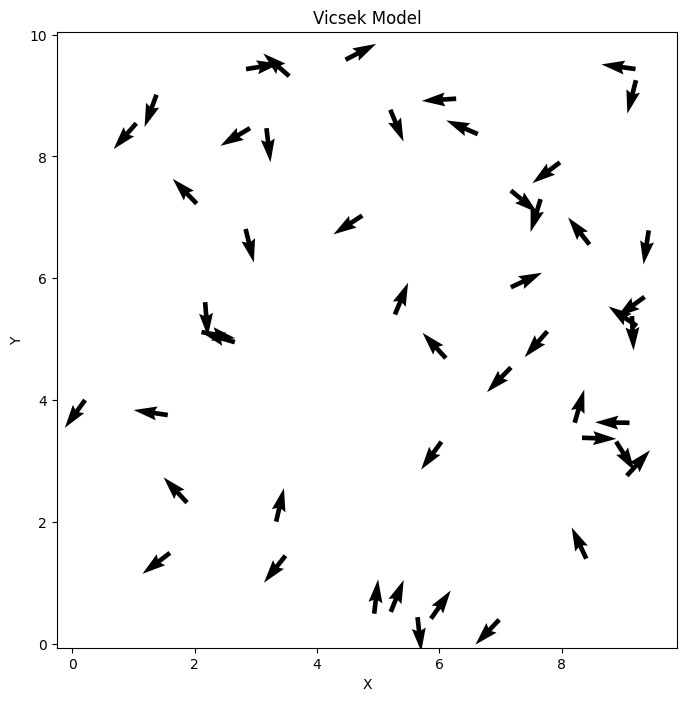

In [230]:
a = animate(trajectories, headings, num_timesteps=50)

In [231]:
HTML(a.to_jshtml())

### Hyperpriors and Conditional Priors

Hyperpriors:

\begin{align}
    \alpha_j, \beta_j   &\sim \mathrm{Gamma}(2, 2), \\
    \varrho_j           &\sim \mathrm{Gamma}(2, 1), \\
    \mu_j               &\sim \mathcal{U}(0, \pi).
\end{align}

Conditional priors: 

\begin{align}
    r     &\sim \mathrm{Gamma}(\varrho_j, 1), \\
    v     &\sim \mathrm{Gamma}(\alpha_j, \beta_j), \\
    \eta_j  &\sim \mathcal{U}(0, \mu_j).
\end{align}

$\eta_j$ is not considered a hyperprior on its own, due to the fact that each agent would theoretically have a different degree of noise magnitude (further sampled from $\mu_j$, which is the hyperprior for $\eta_j$.)

In [385]:
def prior_fun(rng=None):

    if rng is None:
        rng = np.random.default_rng()
    
    # Hyperpriors
    alpha_j = rng.gamma(2,2)
    beta_j = rng.gamma(2,2)
    rho_j = rng.gamma(2,1)
    mu_j = rng.uniform(0, np.pi)

    # Conditional priors
    r = rng.gamma(rho_j, 1)
    v = rng.gamma(alpha_j, beta_j)
    eta = rng.uniform(0, mu_j)

    return np.array([r, v, eta])

In [302]:
test_prior = prior_fun()
test_prior

array([ 0.70641273, 17.46780065,  0.38705075])

In [393]:
test_simulator = simulator_fun(theta=test_prior, num_agents=12)
test_simulator.shape

(101, 12, 3)

In [394]:
prior = bf.simulation.Prior(prior_fun=prior_fun, param_names=PARAM_NAMES)
prior(batch_size=1)

{'prior_draws': array([[0.56696109, 0.55263317, 1.45352428]]),
 'batchable_context': None,
 'non_batchable_context': None}

### Prior Predictive Checks

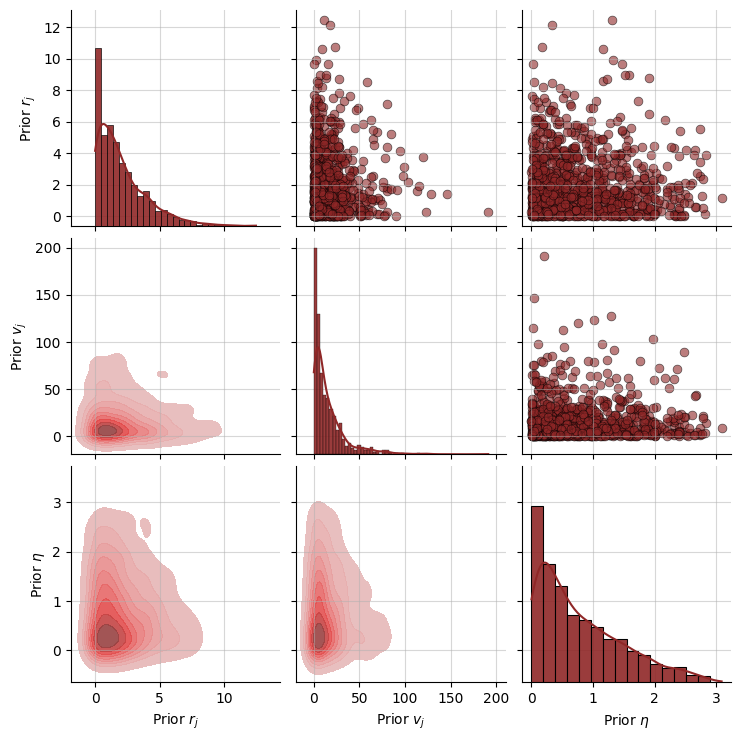

In [395]:
f = prior.plot_prior2d(n_samples=1000)

In [398]:
simulator = bf.simulation.Simulator(
    simulator_fun=partial(simulator_fun, num_agents=12)
)

In [399]:
model = bf.simulation.GenerativeModel(
    prior=prior, simulator=simulator, simulator_is_batched=False
)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 101, 12, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


Making sure that the model works.

In [400]:
test_sim = model(5)
test_sim['sim_data'].shape

(5, 101, 12, 3)

In [401]:
time_stamps = np.linspace(0, 1, test_sim['sim_data'].shape[1])
time_stamps = np.tile(time_stamps[np.newaxis, :, np.newaxis, np.newaxis], (5, 1, 49, 1))
time_stamps.shape

(5, 101, 49, 1)

### Data Configuration and Time-Embedding

In [402]:
def configurator(input_dict):
    output_dict = {}

    theta = input_dict['prior_draws']
    output_dict['parameters'] = theta

    x = input_dict['sim_data']

    # add time encoding to the data x
    batch_size, num_timesteps, num_agents, _ = x.shape
    time_encoding = np.linspace(0, 1, num_timesteps)
    time_encoding_batched = np.tile(
        time_encoding[np.newaxis, :, np.newaxis, np.newaxis], 
        (batch_size, 1, num_agents, 1)
    )

    output_dict['summary_conditions'] = np.concatenate((x, time_encoding_batched), axis=-1)

    return output_dict

In [403]:
out = configurator(test_sim)
out['summary_conditions'].shape

(5, 101, 12, 4)

In [404]:
x = out['summary_conditions']
x[0, :, 1, -1]

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

### Neural Approximator

Currently, it has to be assumed that all data within the timeseries for each agent are considered i.i.d., and therefore, `DeepSet` is used instead of `TimeSeriesTransformer`. It does seem that `TimeSeriesTransformer` is not compatible with `HierarchicalNetwork`. This is something that I will develop into BayesFlow in the future, once I get to know more about how things work between each other.

In [388]:
summary_net = bf.summary_networks.HierarchicalNetwork([
    bf.networks.DeepSet(),
    bf.networks.DeepSet(summary_dim=64)
])

In [381]:
inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=3, 
    num_coupling_layers=6,
    coupling_settings={
        'kernel_regularizer': tf.keras.regularizers.l2(1e-4),
        'dropout_prob': 0.10
    }
)

In [389]:
amortizer = bf.amortizers.AmortizedPosterior(inference_net=inference_net, summary_net=summary_net)

## Training

In [405]:
trainer = bf.trainers.Trainer(
    generative_model=model,
    amortizer=amortizer,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [406]:
amortizer.summary()

Model: "amortized_posterior_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network_4 (Inve  multiple                  605292    
 rtibleNetwork)                                                  
                                                                 
 hierarchical_network_5 (Hi  multiple                  139722    
 erarchicalNetwork)                                              
                                                                 
Total params: 745014 (2.84 MB)
Trainable params: 744978 (2.84 MB)
Non-trainable params: 36 (144.00 Byte)
_________________________________________________________________


In [407]:
# Mini-train to make sure that things work
history = trainer.train_online(epochs=5, iterations_per_epoch=100, batch_size=64)

Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

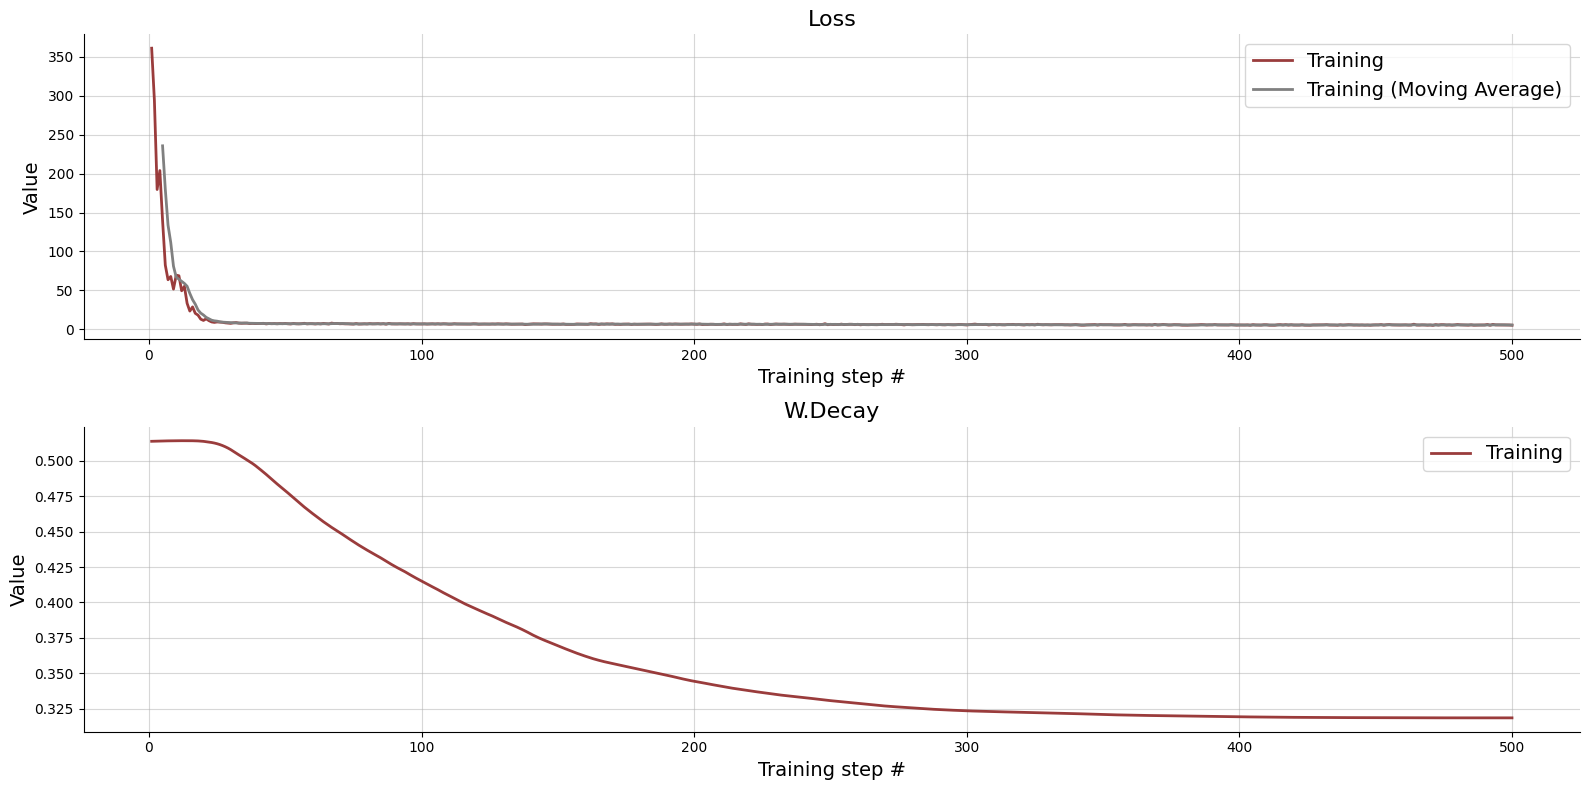

In [410]:
f = bf.diagnostics.plot_losses(history, moving_average=True)

## Validation

In [411]:
validation_sim = model(100)

In [412]:
validation_sim = configurator(validation_sim)

In [429]:
post_samples = amortizer.sample(validation_sim, n_samples=100)
post_samples.shape

(100, 100, 3)

In [417]:
prior_means, prior_stds = prior.estimate_means_and_stds(n_draws=10000)
prior_stds

array([[ 1.96181239, 20.68457701,  0.69403327]])

In [419]:
prior_samples = validation_sim["parameters"] * prior_stds + prior_means

Parameter Recovery

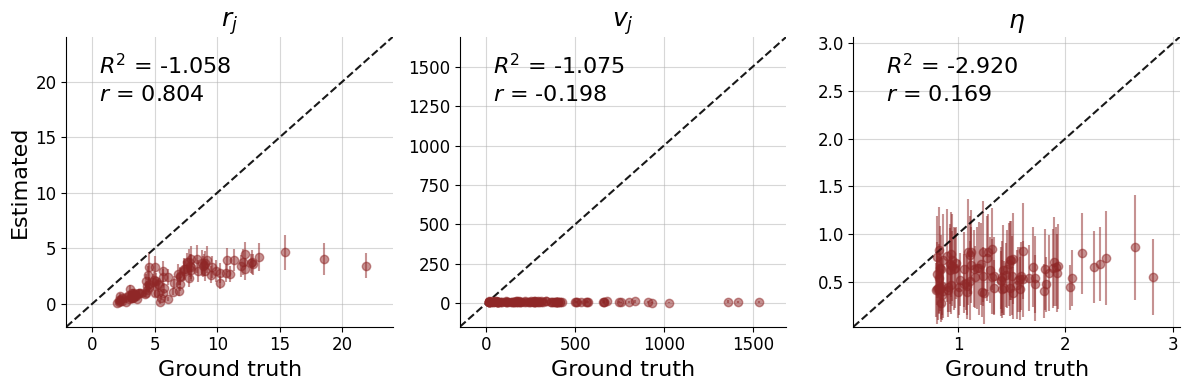

In [420]:
f = bf.diagnostics.plot_recovery(post_samples=post_samples, prior_samples=prior_samples, param_names=PARAM_NAMES)

Simulation-based calibration

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 1.                    Confidence intervals might be unreliable!


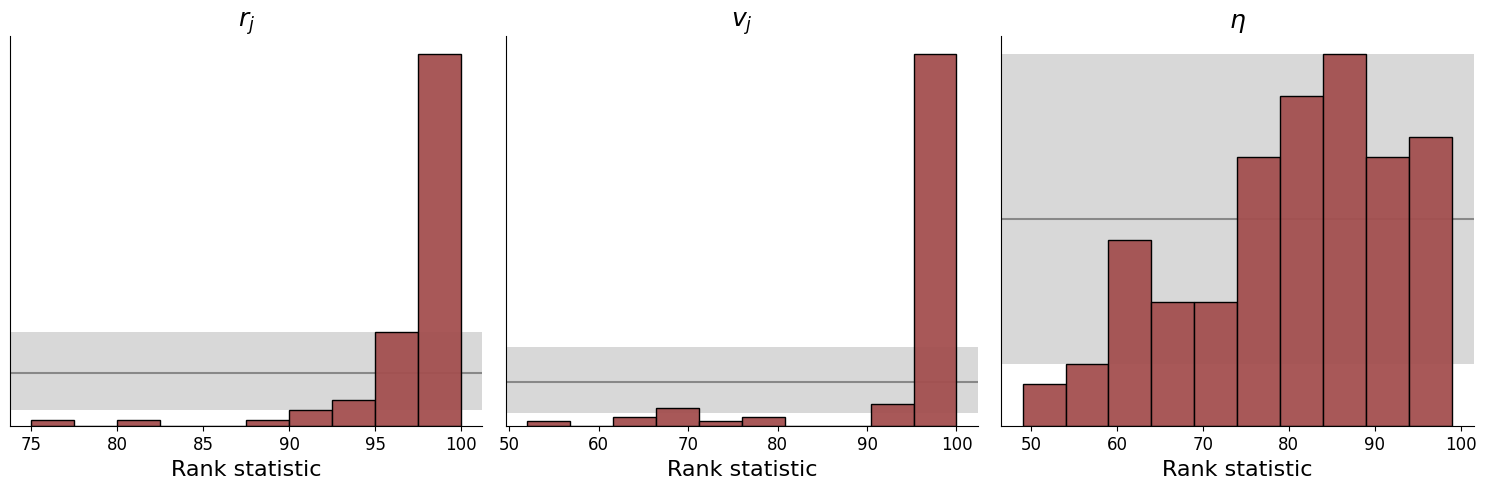

In [422]:
f = bf.diagnostics.plot_sbc_histograms(post_samples=post_samples, prior_samples=prior_samples, param_names=PARAM_NAMES, num_bins=10)

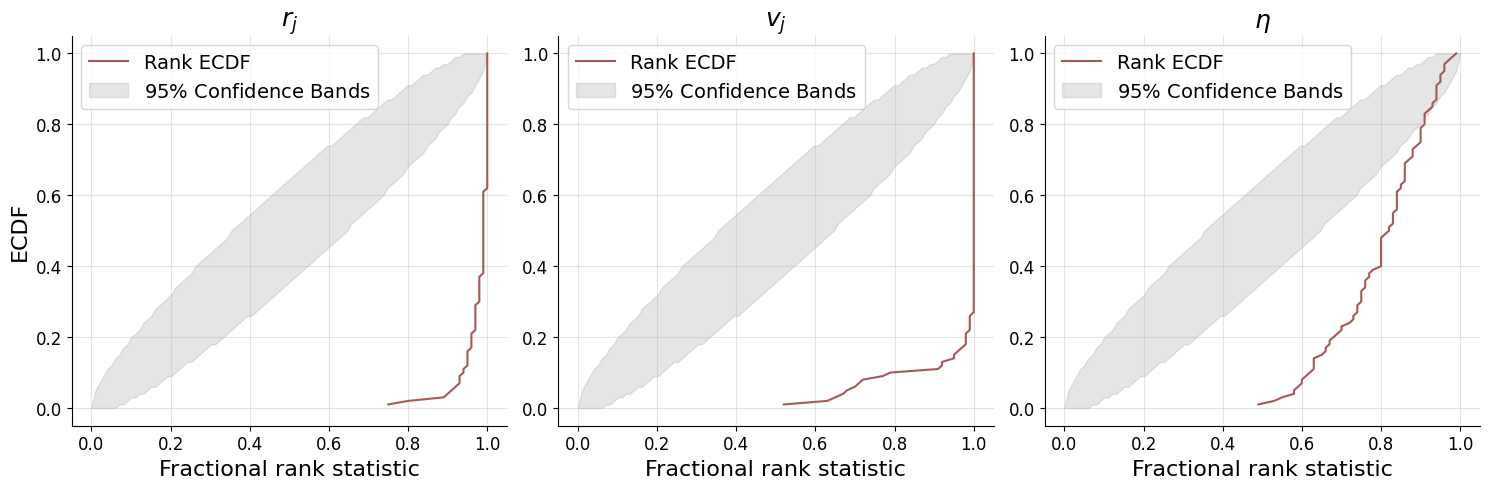

In [424]:
f = bf.diagnostics.plot_sbc_ecdf(post_samples=post_samples, prior_samples=prior_samples, param_names=PARAM_NAMES)

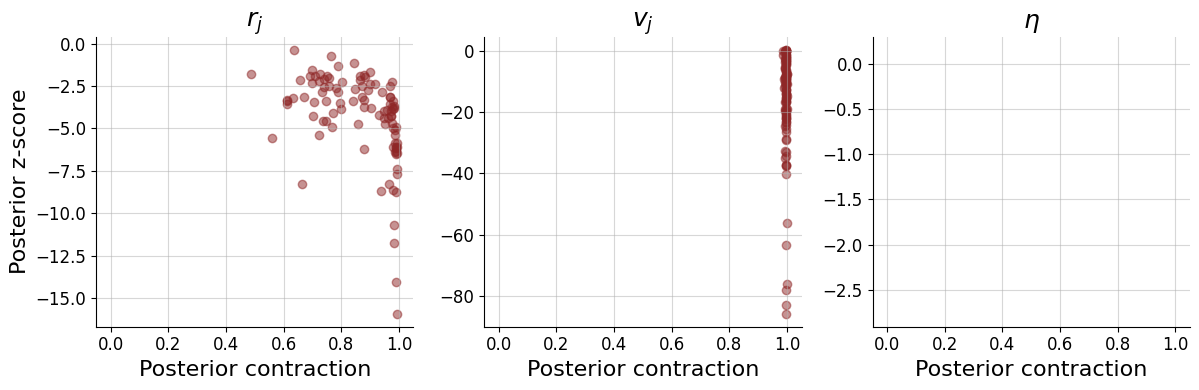

In [425]:
f = bf.diagnostics.plot_z_score_contraction(post_samples=post_samples, prior_samples=prior_samples, param_names=PARAM_NAMES)

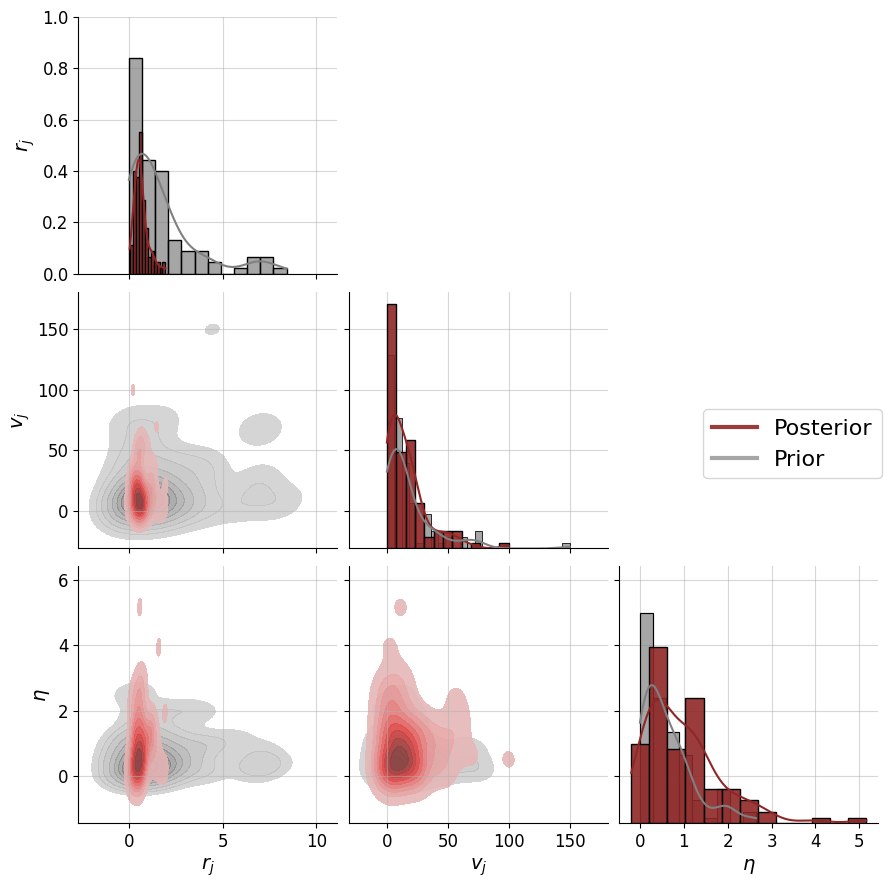

In [430]:
f = bf.diagnostics.plot_posterior_2d(posterior_draws=post_samples[0], prior=prior, param_names=PARAM_NAMES)